In [18]:
# import libraries
from platform import python_version
print(python_version())
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
import matplotlib as mpl

from scipy.signal import butter, lfilter, freqz

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

width  = 2.5
height = width / 1.2

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

3.6.9


In [3]:
# import data to dataframe
# Data rate is 20 HZ

r = 0.3 # wheel radius (m)
B = 1.296 # wheel base (m)
A = 1.52 - r*2
m = 260
g = 9.8

data_05ms = pd.read_csv("./data/0dot5_ms_v2.csv", skiprows=[1])
data_1ms = pd.read_csv("./data/1_ms.csv", skiprows=[1])

print(data_05ms)

      Unnamed: 0             ros_time  joy_switch  icp_index  cmd_left_vel  \
0              1  1637093365406052459       False          1           0.0   
1              2  1637093365456363913       False          1           0.0   
2              3  1637093365506699246       False          2           0.0   
3              4  1637093365557113314       False          2           0.0   
4              5  1637093365607435792       False          3           0.0   
...          ...                  ...         ...        ...           ...   
4969        4970  1637093613858125780       False       2172           0.0   
4970        4971  1637093613911671142       False       2173           0.0   
4971        4972  1637093613961933628       False       2173           0.0   
4972        4973  1637093614012323521       False       2174           0.0   
4973        4974  1637093614062619562       False       2174           0.0   

      meas_left_vel  cmd_right_vel  meas_right_vel  icp_pos_x  

In [4]:
# extract values from dataset

# choose which run to analyse
run = data_05ms

time = run['ros_time'].to_numpy()
time = (time - time[0]) * 10 ** (-9) # time (s)

left_w_vel = run['meas_left_vel'].to_numpy() # left wheel velocity (rad)
right_w_vel = run['meas_right_vel'].to_numpy() # right wheel velocity (rad)

left_voltage = run['voltage_left'].to_numpy() # left wheel voltage (V)
right_voltage = run['voltage_right'].to_numpy() # right wheel voltage (V)

left_current = run['current_left'].to_numpy() # left wheel current (A)
right_current = run['current_right'].to_numpy() # right wheel current (A)

icp_x = run['icp_pos_x'].to_numpy() # icp x position (m)
icp_y = run['icp_pos_y'].to_numpy() # icp y position (m)

icp_quat_x = run['icp_quat_x'].to_numpy()
icp_quat_y = run['icp_quat_y'].to_numpy()
icp_quat_z = run['icp_quat_z'].to_numpy()
icp_quat_w = run['icp_quat_w'].to_numpy()

n_points = time.shape[0]

icp_roll = np.zeros(n_points)
icp_pitch = np.zeros(n_points)
icp_yaw = np.zeros(n_points)

for i in range(0, n_points):
    icp_roll[i], icp_pitch[i], icp_yaw[i] = quaternion_to_euler(icp_quat_w[i], icp_quat_x[i], icp_quat_y[i], icp_quat_z[i]) # icp orientation (rad)

icp_id_arr = run['icp_index'].to_numpy()    

imu_pitch = run['imu_y'].to_numpy()
imu_roll = run['imu_x'].to_numpy()
imu_yaw = run['imu_z'].to_numpy()

print(np.max(imu_yaw))

2.6952474117279053


In [5]:
# Evaluate velocities in body frame

body_to_world = np.eye(2)

vel_world = np.zeros((2, icp_id_arr[-1]))
vel_body = np.zeros((2, icp_id_arr[-1]))
vel_yaw = np.zeros(icp_id_arr[-1])

wheel_vels = np.zeros((2, icp_id_arr[-1])) # [l_wheel_vel, r_wheel_vel] (rad/s)

icp_id = icp_id_arr[0]

prev_pose_i = 0

for i in range(1, n_points):
    
    if icp_id_arr[i] != icp_id:
        dt = time[i] - time[prev_pose_i]
    
        body_to_world = up_propa_mat(body_to_world, icp_yaw[i])
        world_to_body = np.transpose(body_to_world)
        
        vel_world[0, icp_id] = (icp_x[i] - icp_x[prev_pose_i]) / dt
        vel_world[1, icp_id] = (icp_y[i] - icp_y[prev_pose_i]) / dt
        vel_yaw[icp_id] = imu_yaw[i]
        
        vel_body[:, icp_id] = world_to_body @ vel_world[:, icp_id]
        
        wheel_vels[0, icp_id] = left_w_vel[i]
        wheel_vels[1, icp_id] = right_w_vel[i]
        
        icp_id = icp_id_arr[i]
        prev_pose_i = i
        
vel_yaw = np.reshape(vel_yaw, (1, vel_yaw.shape[0]))

(1, 2174)
[0.0, 0.1, 0.2, 0.4, 0.75, 1.25, 2.0, 3.0, 4.0, 5.0]


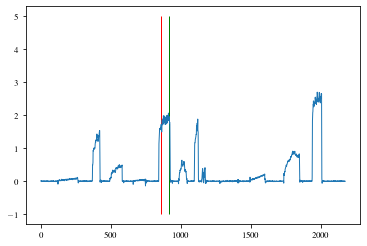

In [6]:
# plt.plot(vel_body[0, :])
# plt.plot(vel_body[1, :])
plt.plot(vel_yaw[0, :])
# plt.plot(wheel_vels[0, :])
# plt.plot(wheel_vels[1, :])

# split data into windows

test_vels = np.array([0.2, 2, 0.75, 0.1, 5, 3, 0, 0.4, 1.25, 4])

windows = np.array([[525, 760, 900, 1050, 1270, 1510, 1680, 1940, 2160, 2360], 
                    [680, 840, 1000, 1150, 1330, 1540, 1810, 2000, 2250, 2410]])
windows = windows - 415

ymax = 5
ymin = -1

# to find windows
window_id = 4
plt.vlines(windows[0, window_id], ymax, ymin, colors = 'r')
plt.vlines(windows[1, window_id], ymax, ymin, colors = 'g')


vels_list = []

print(vel_yaw.shape)
for i in range(0, test_vels.shape[0]):
    vels_arr = np.concatenate((vel_body[:, windows[0,i]:windows[1,i]], vel_yaw[:, windows[0,i]:windows[1,i]], 
                               wheel_vels[:, windows[0,i]:windows[1,i]]), axis = 0)
    vels_list.append(vels_arr)
    
# Re-order vels list
order = [6, 3, 0, 7, 2, 8, 1, 5, 9, 4]
vels_list = [vels_list[i] for i in order]
test_vels = [test_vels[i] for i in order]

print(test_vels)

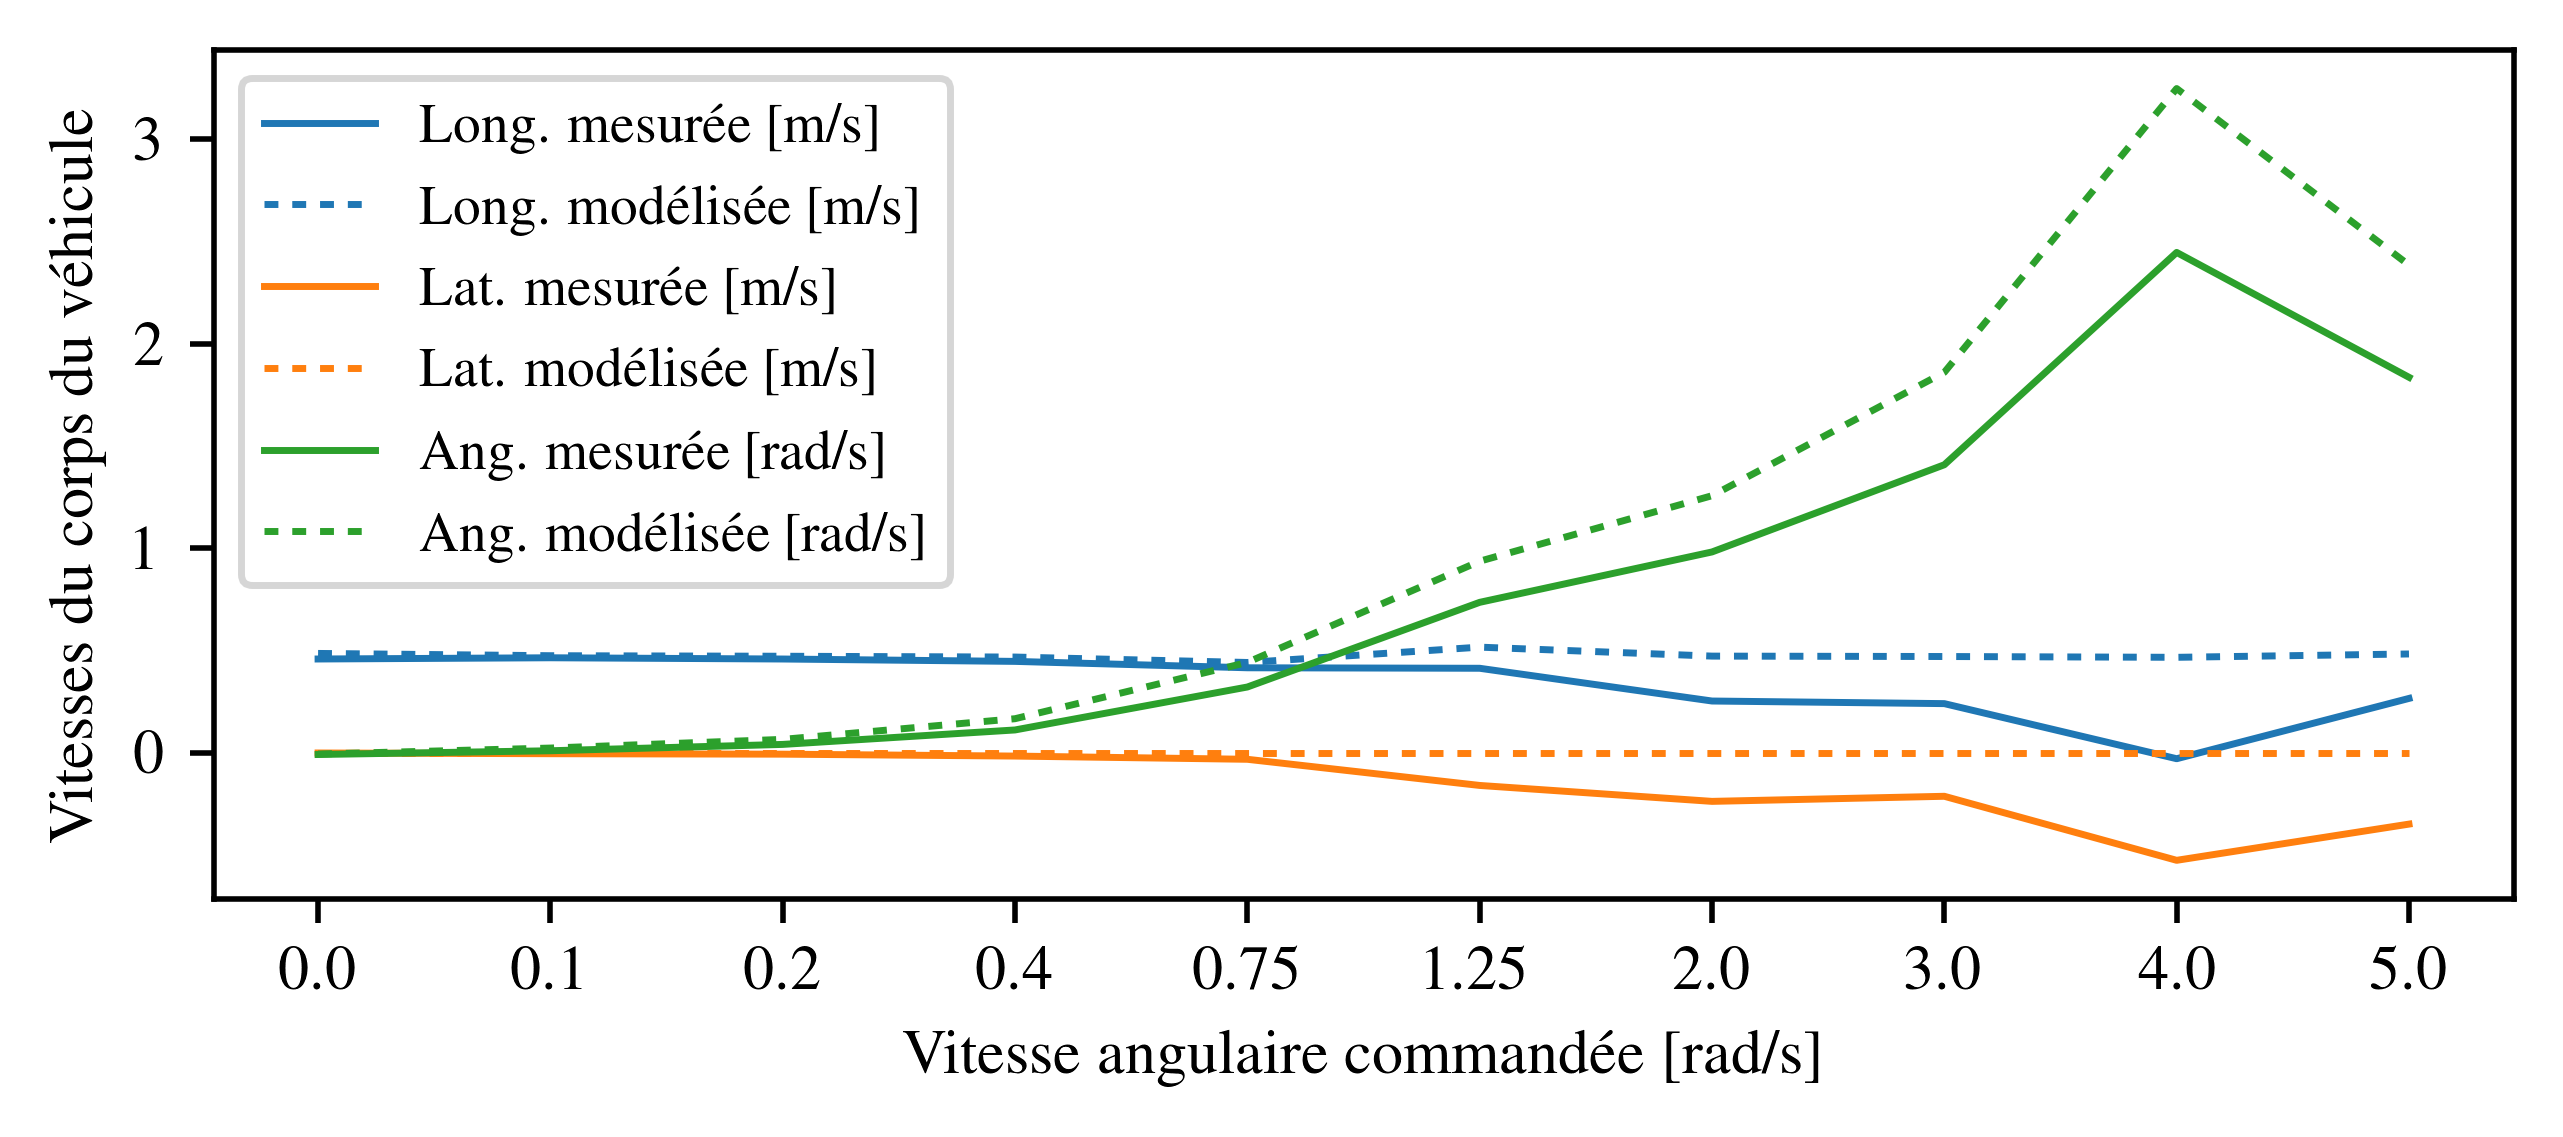

In [20]:
# For every window, compute mean long, lat and ang vels and find commanded wheel vels

Data_medians = np.zeros((len(vels_list), 5)) # long vel, lat vel, ang vel, left w vel, right w vel
model_vels = np.zeros((len(vels_list), 3))

for i in range(0, len(vels_list)):
    Data_medians[i, 0] = np.median(vels_list[i][0, :])
    Data_medians[i, 1] = np.median(vels_list[i][1, :])
    Data_medians[i, 2] = np.median(vels_list[i][2, :])
    Data_medians[i, 3] = np.median(vels_list[i][3, :])
    Data_medians[i, 4] = np.median(vels_list[i][4, :])
    
    model_vels[i, 0] = (Data_medians[i, 3] + Data_medians[i, 4]) * r / 2
    model_vels[i, 2] = (-Data_medians[i, 3] + Data_medians[i, 4]) * r / B
    
# Remove row at 3 ms vel as data is noisy
# Data_medians = np.delete(Data_medians, 7, axis=0)

# test velocity progression

fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height)
fig.subplots_adjust(left=.075, bottom=.18, right=.995, top=.995)
ax.plot(Data_medians[:, 0], c='C0', label = 'Long. mesurée [m/s]')
ax.plot(model_vels[:, 0], c='C0', linestyle='--', label="Long. modélisée [m/s]")
ax.plot(Data_medians[:, 1], c='C1', label = 'Lat. mesurée [m/s]')
ax.plot(model_vels[:, 1], c='C1', linestyle='--', label="Lat. modélisée [m/s]")
ax.plot(Data_medians[:, 2], c='C2', label = 'Ang. mesurée [rad/s]')
ax.plot(model_vels[:, 2], c='C2', linestyle='--', label = 'Ang. modélisée [rad/s]')
ticks = test_vels
# ax.set_title('Measured body velocities for the 0.5 m/s experiment')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(ticks)
ax.set_xlabel('Vitesse angulaire commandée [rad/s]')
ax.set_ylabel('Vitesses du corps du véhicule')

measures = mpl.patches.Patch()
ax.legend(loc='upper left')

# plt.annotate('Long. vel [m/s]', xy=(1, 0.5),xytext=(1, 1.0) , horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
# plt.annotate('Lat. vel [m/s]', xy=(4, 0.0),xytext=(4, 2) , horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
# plt.annotate('Ang. vel [rad/s]', xy=(6, model_vels[6, 2]),xytext=(6, 2) , horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
plt.savefig('figs/body_vels.pdf', dpi=500)

In [8]:
# Compute ICR position and centripetal force

n_runs = Data_medians.shape[0]

icrs = np.zeros((n_runs, 2)) # [x_icr, y_icr]
model_icrs = np.zeros((n_runs, 2))
Fy_icr = np.zeros(n_runs)
Fy_model = np.zeros(n_runs)

for i in range(0, n_runs):
    vx = Data_medians[i, 0]
    vy = Data_medians[i, 1]
    vyaw = Data_medians[i, 2]
    icrs[i, 1] = np.abs(vx / vyaw)
    icrs[i, 0] = np.abs(vy / vyaw)
    Fy_icr[i] = m * np.sqrt(vx**2 + vy**2) / (g * np.sqrt(icrs[i, 0]**2 + icrs[i, 1]**2))
    
    model_icrs[i, 1] = np.abs(model_vels[i, 0] / model_vels[i, 2])
    model_icrs[i, 0] = np.abs(model_vels[i, 1] / model_vels[i, 2])
    Fy_model[i] = m * np.sqrt(model_vels[i, 0]**2 + model_vels[i, 1]**2) / (g * np.sqrt(model_icrs[i, 0]**2 + model_icrs[i, 1]**2))
    
    
print(model_icrs)

[[ 0.         80.136     ]
 [ 0.         20.42608696]
 [ 0.          7.18781538]
 [ 0.          2.808     ]
 [ 0.          0.99903086]
 [ 0.          0.55153398]
 [ 0.          0.37609003]
 [ 0.          0.2530755 ]
 [ 0.          0.14375358]
 [ 0.          0.20263729]]


In [9]:
# Compute slip angles from ICRS

def slip_angle_from_vel(vx, vy, vyaw, x):
    vy_ci = vy + (vyaw * x)
#     if a>0:
#         print('front_vy_c: ', vy_ci)
#     if a<0:
#         print('back_vy_c: ', vy_ci)
    return wrap2pi(np.arctan2(vy_ci, vx))

def slip_angle_from_icr(icr, x, y, angle):
    if (y * icr[1] > 0) and (icr[1] < y):
        return np.arctan((x - icr[0]) / (y - icr[1]))
    else:
        return np.arctan((x - icr[0]) / (icr[1] - y))

slip_angles_vel = np.zeros((n_runs, 4))
slip_angles_icr = np.zeros((n_runs, 4))
wheel_poses = np.array([[A/2, A/2, -A/2, -A/2], 
                       [B/2, -B/2, B/2, -B/2], 
                       [np.pi/2, np.pi/2, -np.pi/2, -np.pi/2]])

slip_angles_icr_model = np.zeros((n_runs, 4))

for i in range(0, n_runs):
    for j in range(0, 4):
        slip_angles_vel[i, j] = slip_angle_from_vel(Data_medians[i, 0], Data_medians[i, 1], Data_medians[i, 2], wheel_poses[0, j])
        slip_angles_icr[i, j] = slip_angle_from_icr(icrs[i], wheel_poses[0, j], wheel_poses[1, j], wheel_poses[2, j])
        slip_angles_icr_model[i, j] = slip_angle_from_icr(model_icrs[i], wheel_poses[0, j], wheel_poses[1, j], wheel_poses[2, j])

print(slip_angles_icr)
print(slip_angles_icr_model)

[[ 6.38913009e-03  6.24141654e-03 -1.04112733e-02 -1.01705803e-02]
 [ 4.76142003e-04  4.62981443e-04 -1.97000322e-02 -1.91556585e-02]
 [ 2.83030795e-02  2.52009254e-02 -5.90483165e-02 -5.25860885e-02]
 [ 9.43816877e-02  6.81595648e-02 -1.77938337e-01 -1.28970395e-01]
 [ 5.11296234e-01  1.84168533e-01 -7.14375224e-01 -2.80327954e-01]
 [ 1.23009880e+00  1.98308455e-01 -1.44414788e+00 -5.10107067e-01]
 [ 5.09973993e-01  2.36409780e-01 -1.06337942e+00 -6.59136967e-01]
 [ 5.74671213e-01  3.60955428e-01 -9.07619073e-01 -6.41059468e-01]
 [ 3.67807655e-01  3.55728027e-01 -8.14890692e-01 -7.96659169e-01]
 [ 4.92680577e-01  3.28376641e-01 -9.11944075e-01 -6.86637886e-01]]
[[ 0.00578697  0.00569414 -0.00578697 -0.00569414]
 [ 0.02325387  0.02182429 -0.02325387 -0.02182429]
 [ 0.07022272  0.05863751 -0.07022272 -0.05863751]
 [ 0.20982831  0.13232409 -0.20982831 -0.13232409]
 [ 0.91895713  0.27235062 -0.91895713 -0.27235062]
 [ 1.36408311  0.36618635 -1.36408311 -0.36618635]
 [ 1.03694025  0.422171

[0.0, 0.1, 0.2, 0.4, 0.75, 1.25, 2.0, 3.0, 4.0, 5.0]


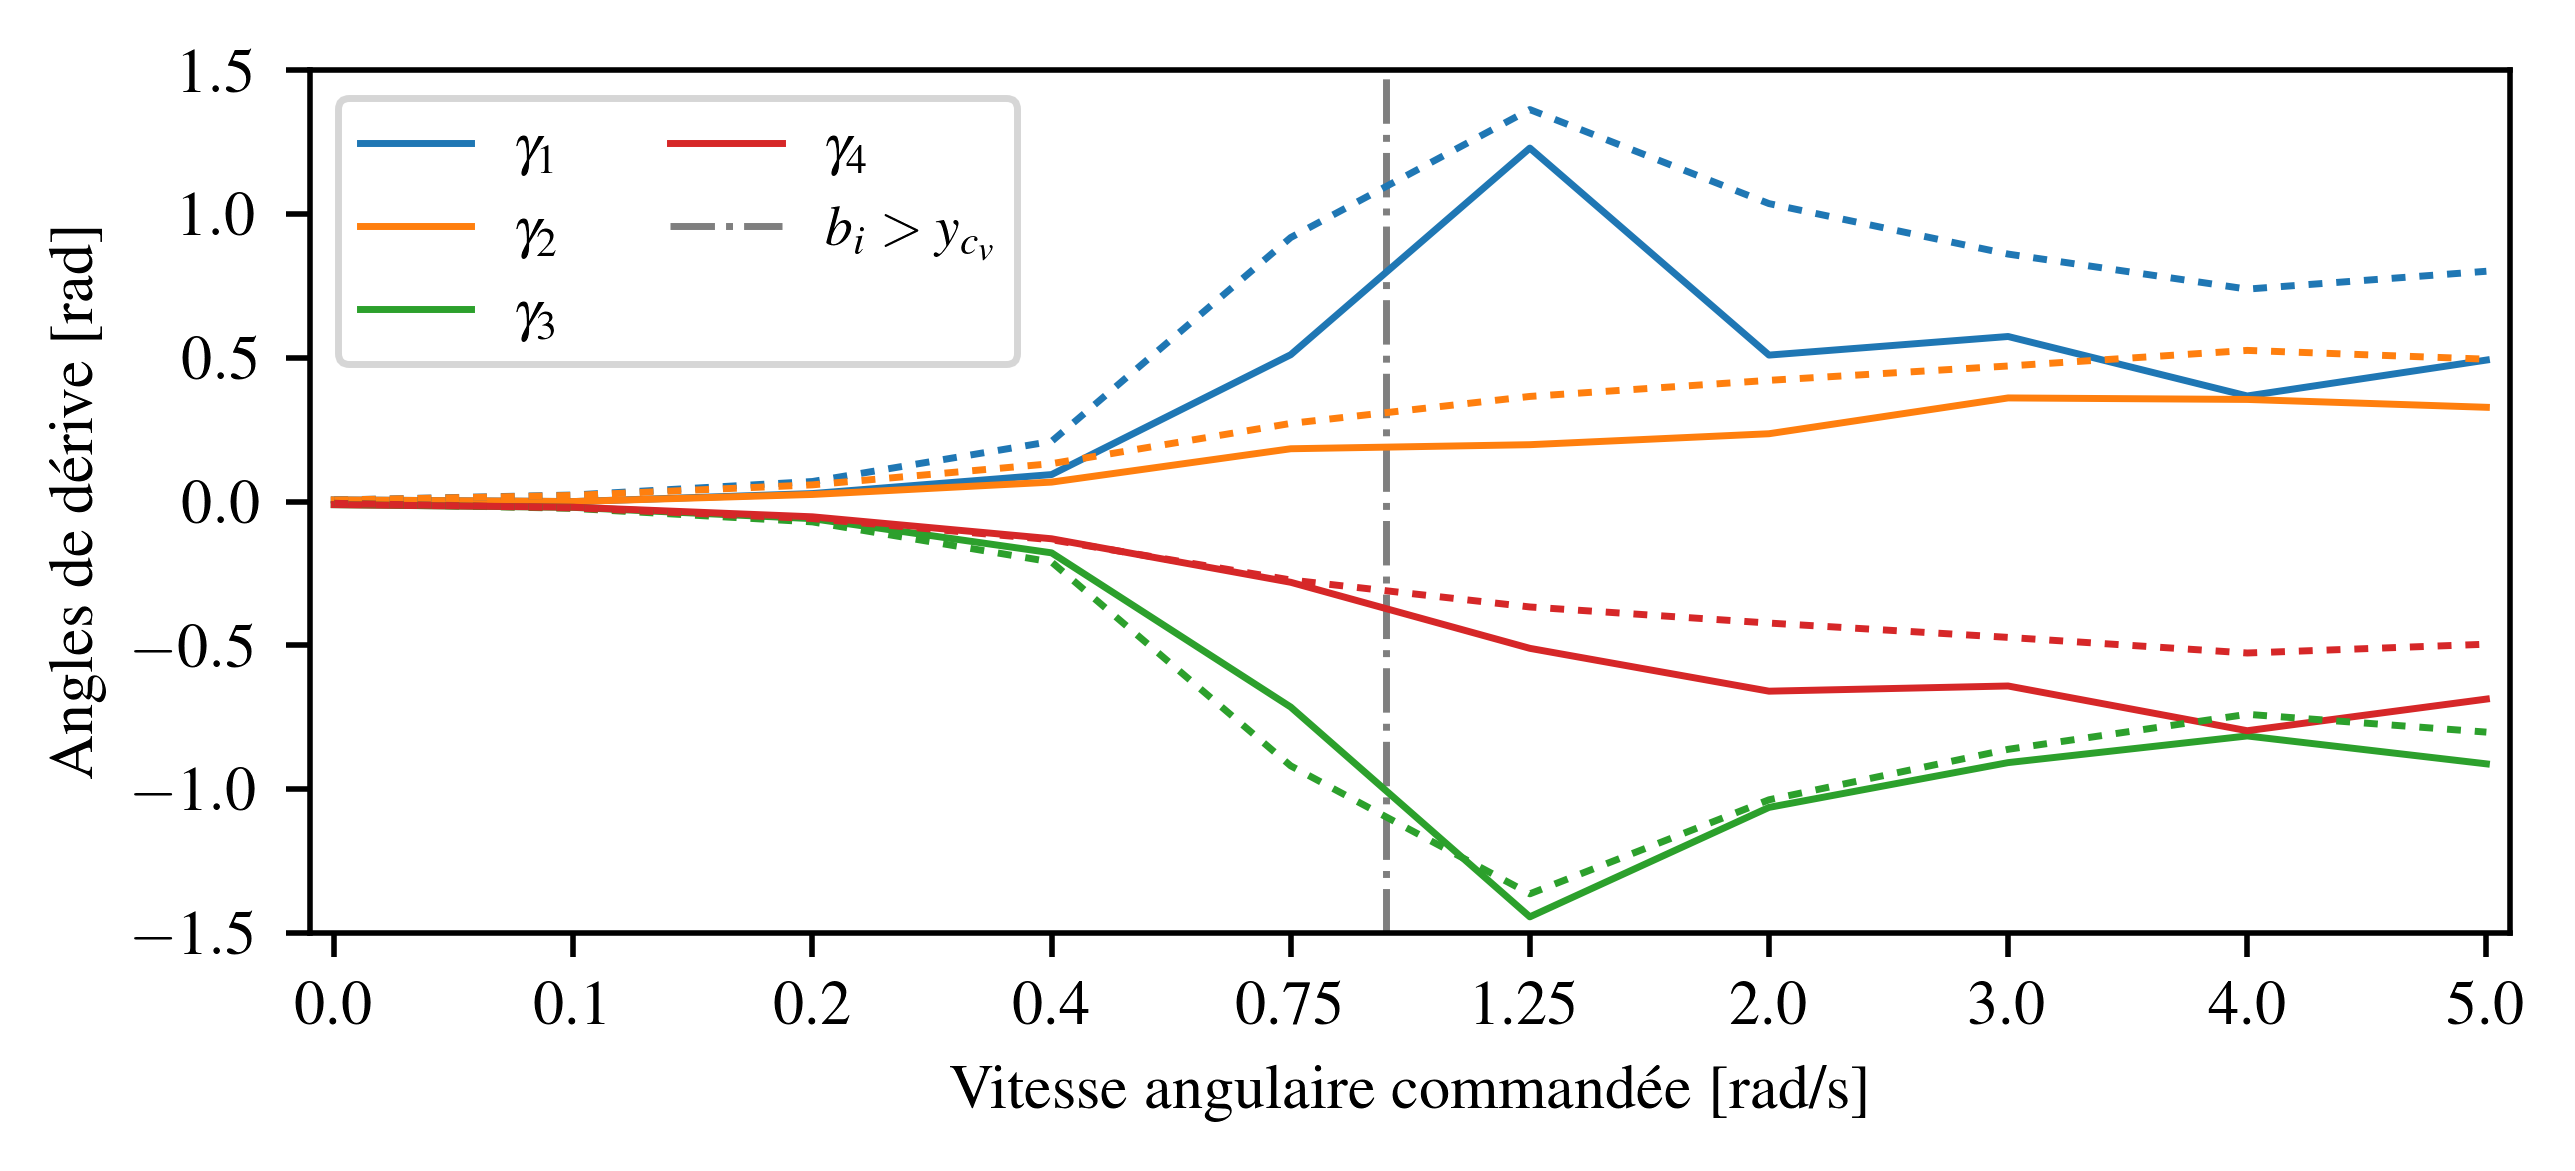

In [37]:
# plot model inputs

fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height+0.1)
fig.subplots_adjust(left=.11, bottom=.18, right=.99, top=.97)
plt.plot(slip_angles_icr[:, 0], c='C0', label = '$\gamma_1$')
plt.plot(slip_angles_icr[:, 1], c='C1', label = '$\gamma_2$')
plt.plot(slip_angles_icr[:, 2], c='C2', label = '$\gamma_3$')
plt.plot(slip_angles_icr[:, 3], c='C3', label = '$\gamma_4$')

plt.plot(slip_angles_icr_model[:, 0], c='C0', linestyle = '--')
plt.plot(slip_angles_icr_model[:, 1], c='C1', linestyle = '--')
plt.plot(slip_angles_icr_model[:, 2], c='C2', linestyle = '--')
plt.plot(slip_angles_icr_model[:, 3], c='C3', linestyle = '--')

ax.vlines(4.4, -1.5, 1.5, colors='C7', linestyle='-.', label='$b_i > y_{c_v}$')

# plt.plot(slip_angles_vel[:, 0], label = 'Wheel 1 slip angle [rad]')
# plt.plot(slip_angles_vel[:, 1], label = 'Wheel 2 slip angle [rad]')
# plt.plot(slip_angles_vel[:, 2], label = 'Wheel 3 slip angle [rad]')
# plt.plot(slip_angles_vel[:, 3], label = 'Wheel 4 slip angle [rad]')
# ticks = np.delete(test_vels, 7, axis=0)
ticks = test_vels
print(ticks)
# ax.set_title('Contact force inputs for the 0.5 m/s experiment')
ax.set_xlim(-0.1, 9.1)
ax.set_ylim(-1.5, 1.5)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(ticks)
ax.set_xlabel('Vitesse angulaire commandée [rad/s]')
ax.set_ylabel('Angles de dérive [rad]')
ax.legend(loc='upper left', ncol=2)

# plt.annotate('ICR passes wheelbase', xy=(4.4, -1.2),xytext=(1, -1.2) , horizontalalignment="left", arrowprops=dict(arrowstyle='->',lw=1))
plt.savefig('figs/slip_angles.pdf', dpi=500)

In [39]:
# Compute slip angle for each vel and estimate lateral forces through linear model

def piecewise_linear(slip_qty, C):
    return slip_qty * C

def compute_lat_vel(vx, vy, vyaw, a):
    return vy + a * vyaw

C_skid = -32
C_slip_angle = -30

cpoints_vels = np.zeros((n_runs, 4))
cpoints_vels_model = np.zeros((n_runs, 4))
a_arr = np.array([A/2, A/2, -A/2, -A/2])
Fy_skid_vel = np.zeros(n_runs)
Fy_skid_vel_model = np.zeros(n_runs)
Fy_slip_angle = np.zeros(n_runs)
Fy_slip_angle_model = np.zeros(n_runs)

for i in range(0, n_runs):
    vx = Data_medians[i, 0]
#     print('vx: ', vx)
    vy = Data_medians[i, 1]
#     print('vy: ', vy)
    vyaw = Data_medians[i, 2]
#     print('vyaw: ', vyaw)
    for j in range(0, 4):
        cpoints_vels[i, j] = compute_lat_vel(vx, vy, vyaw, a_arr[j])
        cpoints_vels_model[i, j] = compute_lat_vel(model_vels[i, 0], model_vels[i, 1], model_vels[i, 2], a_arr[j])
        
        Fy_skid_vel[i] = Fy_skid_vel[i] + piecewise_linear(cpoints_vels[i,j], C_skid)
        Fy_skid_vel_model[i] = Fy_skid_vel_model[i] + piecewise_linear(cpoints_vels_model[i,j], C_skid)
        
#         Fy_slip_angle[i] = Fy_slip_angle[i] + piecewise_linear(slip_angles_icr[i,j], C_slip_angle)
        Fy_slip_angle[i] = Fy_slip_angle[i] + piecewise_linear(slip_angles_icr[i,j], C_slip_angle)
        Fy_slip_angle_model[i] = Fy_slip_angle_model[i] + piecewise_linear(slip_angles_icr_model[i,j], C_slip_angle)
        

print(Fy_slip_angle)
print(Fy_slip_angle_model)

[ 0.23853921  1.13749702  1.74391201  4.33102439  8.97715235 15.77543056
 29.28397853 18.391557   26.64042537 23.3257423 ]
[ 0.00000000e+00  0.00000000e+00  2.22044605e-16  4.44089210e-16
 -3.55271368e-15 -3.55271368e-15 -3.55271368e-15  1.77635684e-15
 -3.55271368e-15 -3.55271368e-15]


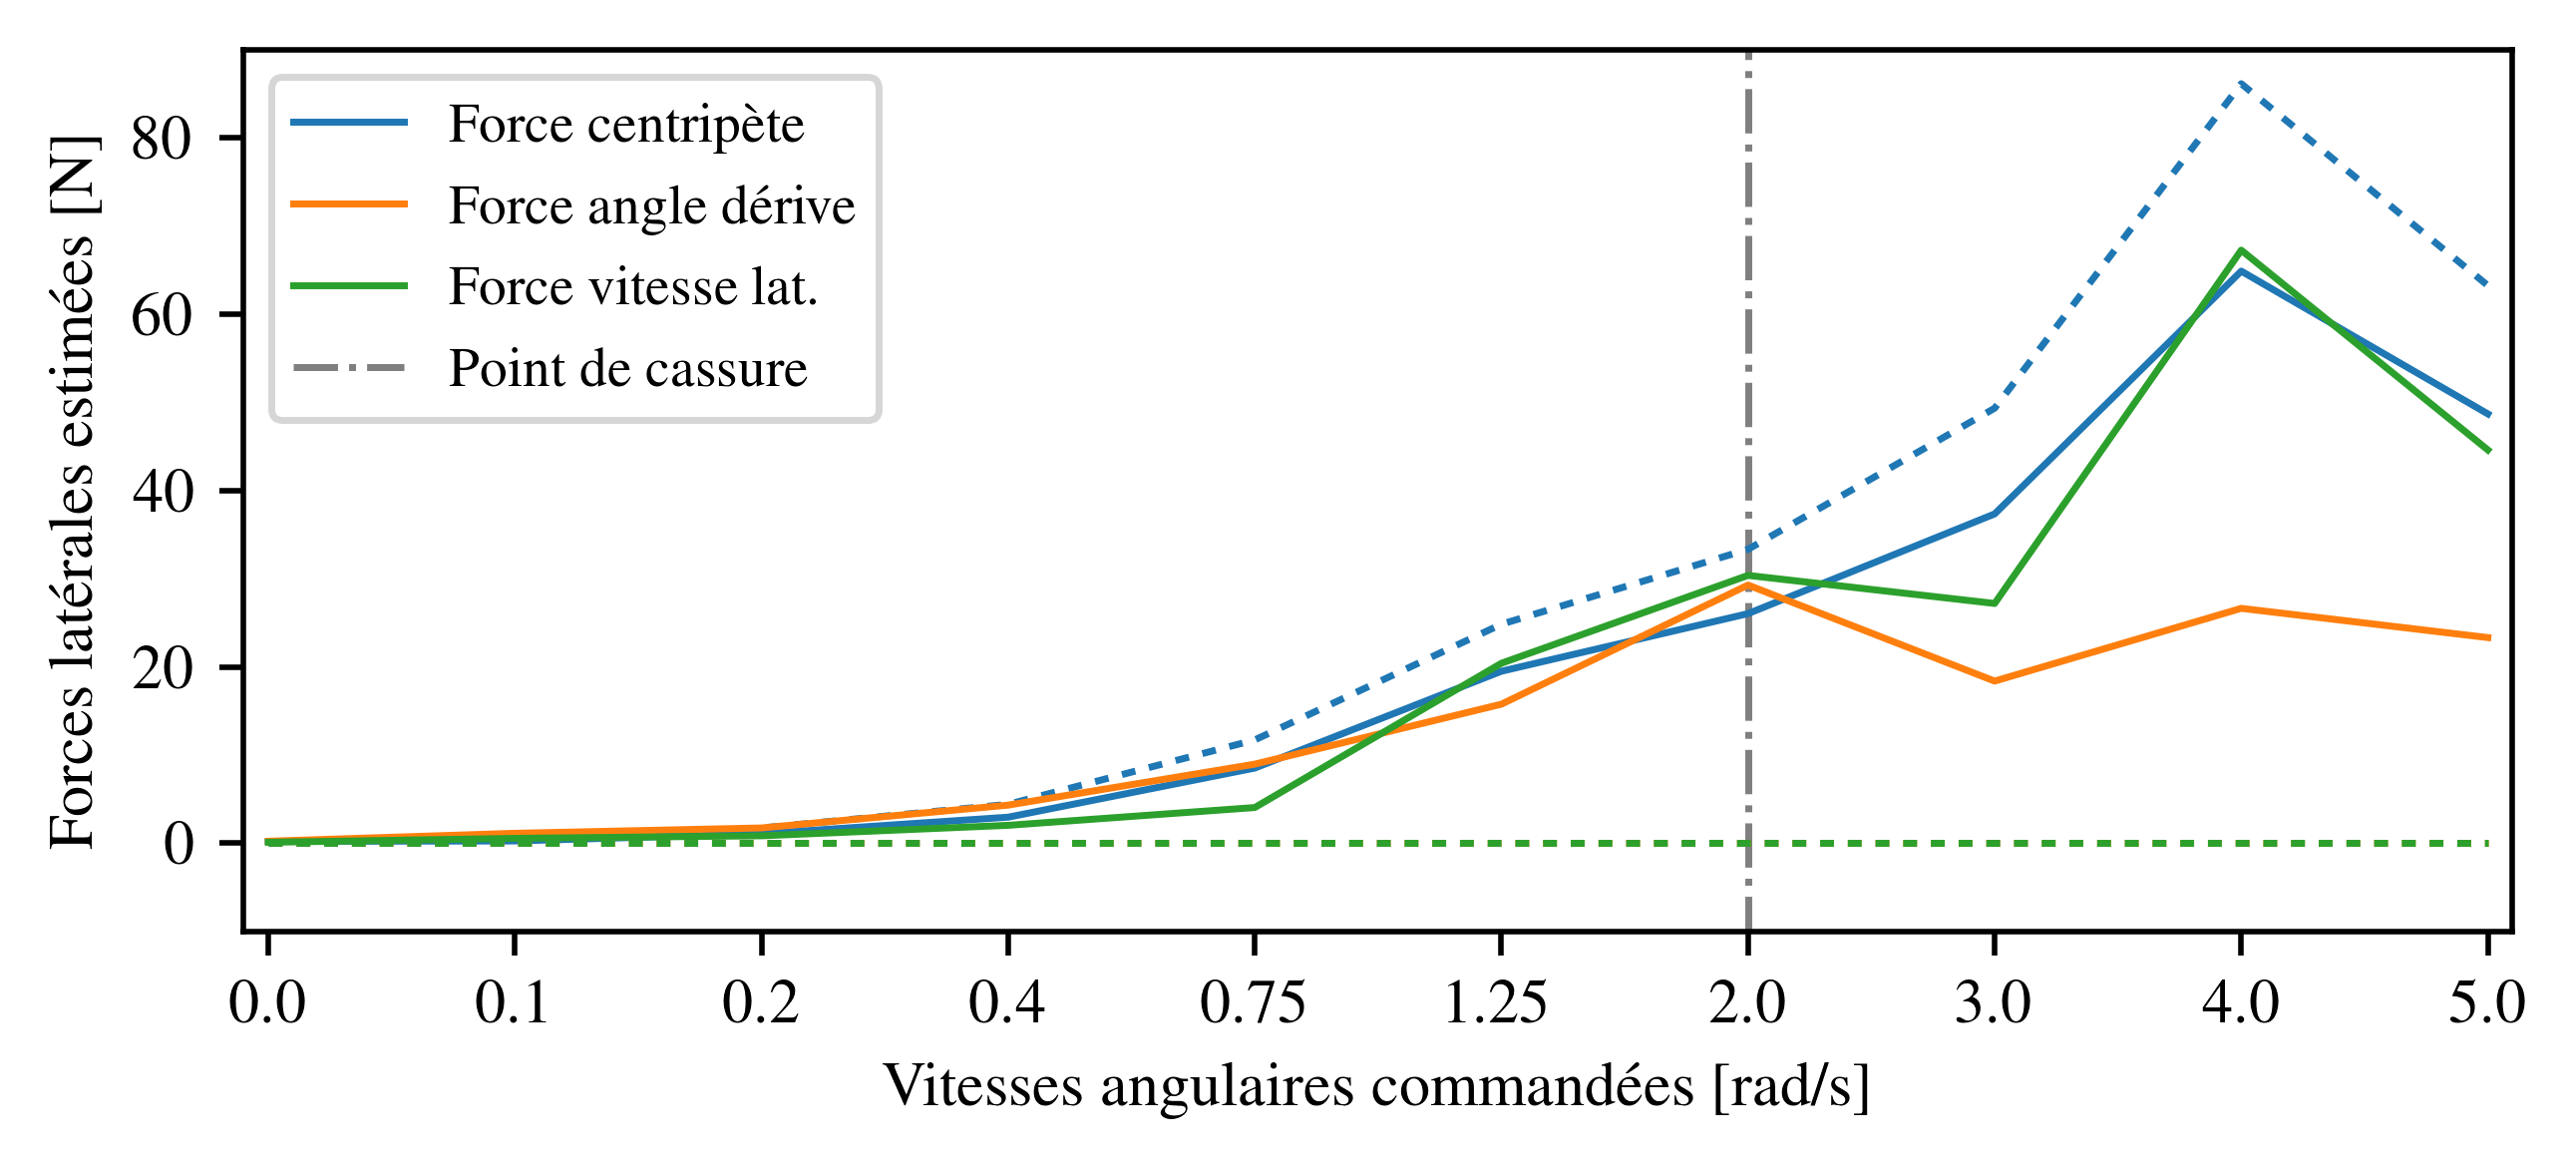

In [43]:
fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height+0.1)
fig.subplots_adjust(left=.08, bottom=.18, right=.99, top=.99)
ax.plot(Fy_icr, c='C0', label='Force centripète')
ax.plot(Fy_model, c='C0', linestyle='--')
ax.plot(Fy_slip_angle, c='C1', label='Force angle dérive')
ax.plot(Fy_slip_angle_model, c='C1', linestyle='--')
ax.plot(Fy_skid_vel, c='C2', label='Force vitesse lat.')
ax.plot(Fy_skid_vel_model, c='C2', linestyle='--')

ax.vlines(6, -11, 95, colors='C7', linestyle='-.', label='Point de cassure')

# ax.set_title('Lateral forces for the 0.5 m/s experiment')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(ticks)
ax.set_xlabel('Vitesses angulaires commandées [rad/s]')
ax.set_ylabel('Forces latérales estimées [N]')
ax.legend(loc='upper left')
ax.set_xlim(-0.1, 9.1)
ax.set_ylim(-10, 90)


# plt.annotate("D'alembert", xy=(7, Fy_model[7]),xytext=(7.2, Fy_model[7] + 20) , horizontalalignment="right", arrowprops=dict(arrowstyle='->',lw=1, color='C0'), c='C0')
# plt.annotate("Vitesse latérale", xy=(8, Fy_skid_vel[8]),xytext=(7.8, Fy_skid_vel[8] + 15) , horizontalalignment="right", arrowprops=dict(arrowstyle='->',lw=1, color='C2'), c='C2')
# plt.annotate("Slip angle", xy=(8, Fy_slip_angle[8]),xytext=(8, Fy_slip_angle[8] - 20) , horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1, color='C1'), c='C1')
# plt.annotate("80 \% du temps d'opération", xy=(2.5, 81),xytext=(4.5, 80) , horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1, color='k'), c='k')


# plt.annotate('Point de cassure', xy=(6, 50),xytext=(3, 48) , horizontalalignment="left", arrowprops=dict(arrowstyle='->',lw=1, color='C7'), c='C7')
plt.savefig('figs/lateral_forces.pdf', dpi=500)

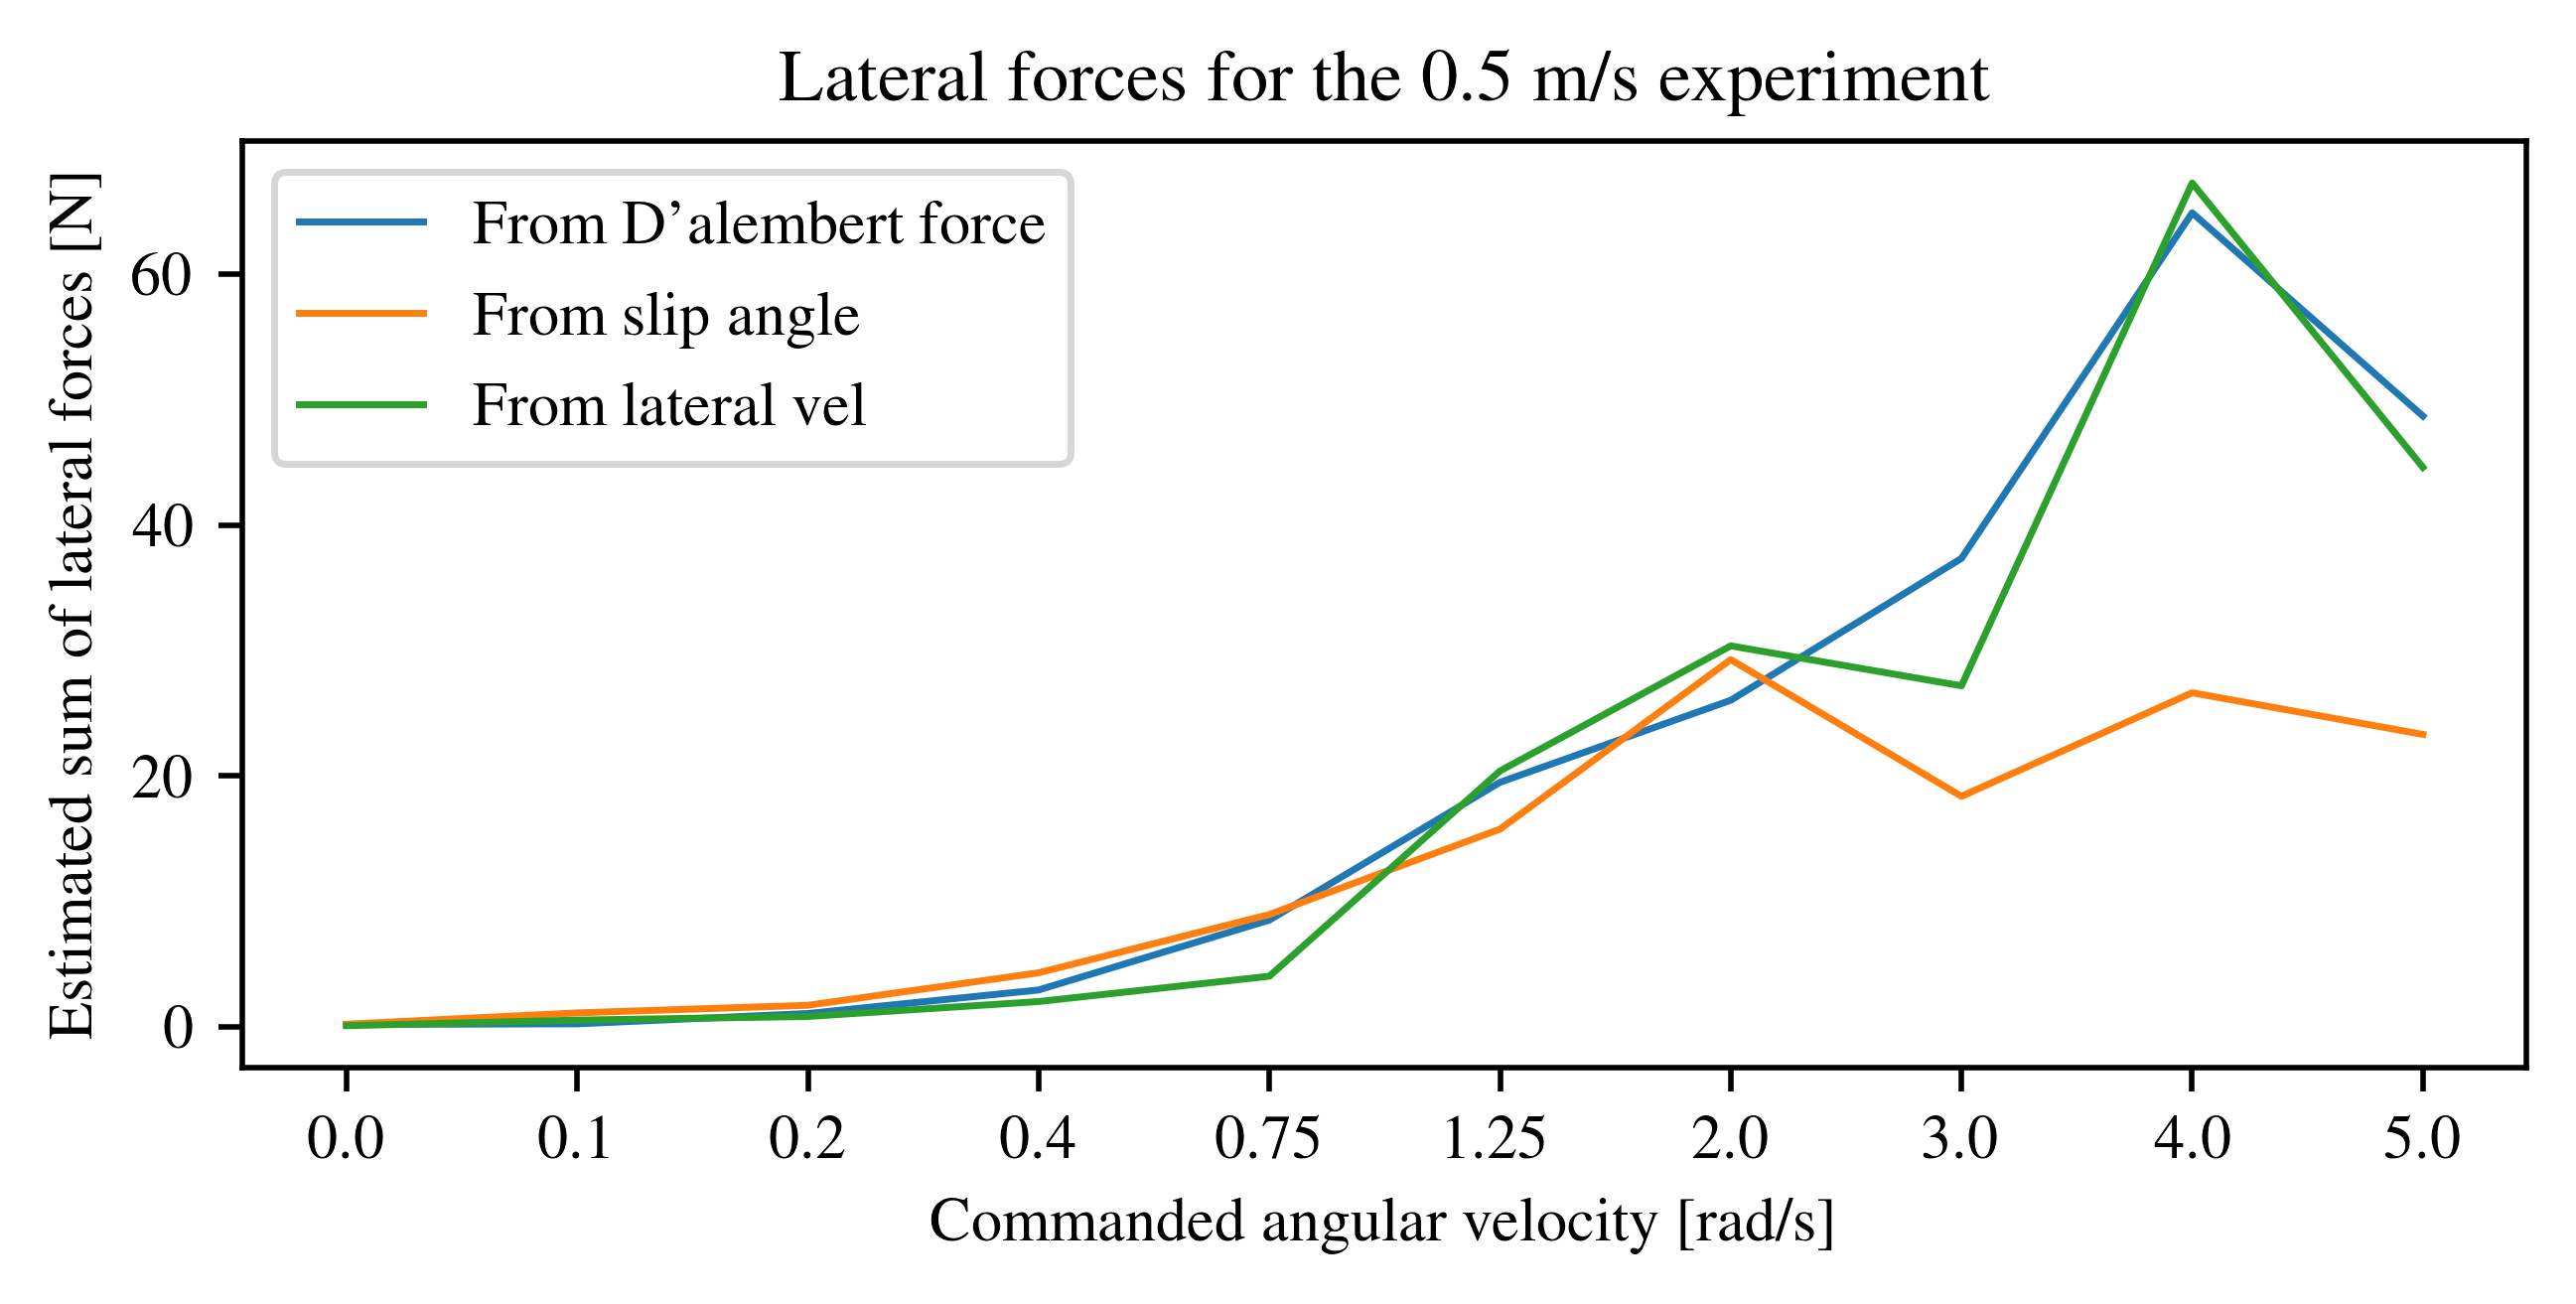

In [12]:
# Gradual graph

fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height+0.1)
fig.subplots_adjust(left=.075, bottom=.14, right=.995, top=.995)


plt.plot(Fy_icr, label="From D'alembert force")
plt.plot(Fy_slip_angle, label='From slip angle')
plt.plot(Fy_skid_vel, label = 'From lateral vel')


ax.set_title('Lateral forces for the 0.5 m/s experiment')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(ticks)
ax.set_xlabel('Commanded angular velocity [rad/s]')
ax.set_ylabel('Estimated sum of lateral forces [N]')
ax.legend(loc='upper left')

In [13]:
# Compute C through inverse dynamics

C_inv = np.zeros(n_runs)

for i in range(0, n_runs):
    C_inv[i] = Fy_icr[i] / (2 * (slip_angles[i, 0] + slip_angles[i, 2]))
    
C_inv = np.delete(C_inv, [7,8], axis=0)

NameError: name 'slip_angles' is not defined

In [ ]:
plt.plot(C_inv)

In [ ]:
plt.plot(vel_body[0, :])
plt.plot(vel_body[1, :])
plt.plot(vel_yaw)
# plt.plot(vel_yaw_filtered)

# split data into windows

test_vels = np.array([0.2, 2, 0.75, 0.1, 5, 3, 0, 0.4, 1.25, 4])

windows = np.array([[525, 760, 900, 1050, 1240, 1380, 1680, 1880, 2140, 2340], 
                    [680, 840, 1000, 1150, 1330, 1450, 1810, 2000, 2250, 2420]])

windows = windows - 415

ymax = 5
ymin = -1

# to find windows
window_id = 8
plt.vlines(windows[0, window_id], ymax, ymin, colors = 'r')
plt.vlines(windows[1, window_id], ymax, ymin, colors = 'g')


vels_list = []
for i in range(0, test_vels.shape[0]):
    vels_list.append(vel_body[:, windows[0,i]:windows[1,i]])
    
# NEED TO ADD YAW VELOCITIES THERE, ADD IMU DATA


In [ ]:
# Compute average velocities